In gene_2401_df.csv there are duplicate gene symbols, for the same entrez ID. Let's investigate why 
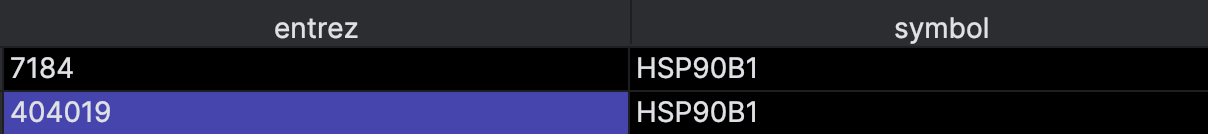

In [1]:
! pip install biopython --quiet

In [31]:
from Bio import Entrez
import pandas as pd

GENES_PATH = "../data/genes/genes_2401_df.csv"

Entrez.email = "nadib00@zedat.fu-berlin.de"  # required by entrez
df = pd.read_csv(GENES_PATH)
df.head()

,entrez,symbol
0,8200,GDF5
1,8202,NCOA3
2,8204,NRIP1
3,139285,AMER1
4,8216,LZTR1


In [32]:
dup_df = df[df.duplicated(subset='symbol')]
dup_df

,entrez,symbol
2398,404019,HSP90B1


In [33]:
problem_symbol = dup_df.symbol.values[0]
problem_symbol

'HSP90B1'

In [34]:
problem_df = df[df.symbol == problem_symbol]
problem_df.head()

,entrez,symbol
2180,7184,HSP90B1
2398,404019,HSP90B1


In [48]:
def fetch_entrez_entry(entrez_id: int) -> dict:
    handle = Entrez.efetch(db="gene", id=entrez_id, retmode="xml")
    records = Entrez.read(handle)
    handle.close()
    return records[0]

In [50]:
def fetch_gene_info(entrez_id: int) -> dict:
    record = fetch_entrez_entry(entrez_id)
    return record['Entrezgene_gene']['Gene-ref']  

fetch_gene_info("3320")

{'Gene-ref_locus': 'HSP90AA1', 'Gene-ref_desc': 'heat shock protein 90 alpha family class A member 1', 'Gene-ref_maploc': '14q32.31', 'Gene-ref_db': [{'Dbtag_db': 'HGNC', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'HGNC:5253'}}}, {'Dbtag_db': 'Ensembl', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'ENSG00000080824'}}}, {'Dbtag_db': 'MIM', 'Dbtag_tag': {'Object-id': {'Object-id_id': '140571'}}}, {'Dbtag_db': 'AllianceGenome', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'HGNC:5253'}}}], 'Gene-ref_syn': ['EL52', 'HSPN', 'LAP2', 'HSP86', 'HSPC1', 'HSPCA', 'Hsp89', 'Hsp90', 'LAP-2', 'HSP89A', 'HSP90A', 'HSP90N', 'Hsp103', 'HSPCAL1', 'HSPCAL4', 'HEL-S-65p'], 'Gene-ref_formal-name': {'Gene-nomenclature': {'Gene-nomenclature_status': StringElement('', attributes={'value': 'official'}), 'Gene-nomenclature_symbol': 'HSP90AA1', 'Gene-nomenclature_name': 'heat shock protein 90 alpha family class A member 1', 'Gene-nomenclature_source': {'Dbtag': {'Dbtag_db': 'HGNC', 'Dbtag_tag': {'Object-id': {

In [51]:
def fetch_gene_symbol_and_desc(entrez_id: int) -> pd.Series:
    """Fetch official gene symbol and description using Entrez ID."""
    gene_info = fetch_gene_info(entrez_id)
    symbol = gene_info.get('Gene-ref_locus', '')
    description = gene_info.get('Gene-ref_desc', '')
    return pd.Series([symbol, description])

In [52]:
problem_df[['gene_symbol_official', 'gene_description']] = problem_df['entrez'].apply(
    lambda eid: fetch_gene_symbol_and_desc(eid)
)
problem_df

/var/folders/hz/19nx8z9n3y10jrc842qwt7h80000gn/T/ipykernel_90180/1038245026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  problem_df[['gene_symbol_official', 'gene_description']] = problem_df['entrez'].apply(


,entrez,symbol,gene_symbol_official,gene_description
2180,7184,HSP90B1,HSP90B1,heat shock protein 90 beta family member 1
2398,404019,HSP90B1,HSP90B1,heat shock protein 90 beta family member 1


It's actually true! For these two IDs, we get the same gene symbol. But why are the features different then?

In [40]:
def search_gene_symbol(symbol, organism="Homo sapiens"):
    query = f"{symbol}[Gene Name] AND {organism}[Organism]"
    handle = Entrez.esearch(db="gene", term=query, retmode="xml")
    record = Entrez.read(handle)
    handle.close()
    return record["IdList"]  # List of matching Entrez IDs

In [41]:
search_gene_symbol(problem_symbol)

['7184']

In [44]:
fetch_gene_info(404019)

{'Gene-ref_locus': 'HSP90B1', 'Gene-ref_desc': 'heat shock protein 90 beta family member 1', 'Gene-ref_db': [{'Dbtag_db': 'VGNC', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'VGNC:54212'}}}, {'Dbtag_db': 'Ensembl', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'ENSCAFG00845010421'}}}, {'Dbtag_db': 'RGD', 'Dbtag_tag': {'Object-id': {'Object-id_id': '12337614'}}}], 'Gene-ref_syn': ['TRA1', 'GRP94'], 'Gene-ref_formal-name': {'Gene-nomenclature': {'Gene-nomenclature_status': StringElement('', attributes={'value': 'official'}), 'Gene-nomenclature_symbol': 'HSP90B1', 'Gene-nomenclature_name': 'heat shock protein 90 beta family member 1', 'Gene-nomenclature_source': {'Dbtag': {'Dbtag_db': 'VGNC', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'VGNC:54212'}}}}}}}

In [45]:
fetch_gene_info(7184)

{'Gene-ref_locus': 'HSP90B1', 'Gene-ref_desc': 'heat shock protein 90 beta family member 1', 'Gene-ref_maploc': '12q23.3', 'Gene-ref_db': [{'Dbtag_db': 'HGNC', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'HGNC:12028'}}}, {'Dbtag_db': 'Ensembl', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'ENSG00000166598'}}}, {'Dbtag_db': 'MIM', 'Dbtag_tag': {'Object-id': {'Object-id_id': '191175'}}}, {'Dbtag_db': 'AllianceGenome', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'HGNC:12028'}}}], 'Gene-ref_syn': ['ECGP', 'GP96', 'TRA1', 'GRP94', 'HEL35', 'HEL-S-125m'], 'Gene-ref_formal-name': {'Gene-nomenclature': {'Gene-nomenclature_status': StringElement('', attributes={'value': 'official'}), 'Gene-nomenclature_symbol': 'HSP90B1', 'Gene-nomenclature_name': 'heat shock protein 90 beta family member 1', 'Gene-nomenclature_source': {'Dbtag': {'Dbtag_db': 'HGNC', 'Dbtag_tag': {'Object-id': {'Object-id_str': 'HGNC:12028'}}}}}}}

It's a dog gene! loool

In [46]:
search_gene_symbol(problem_symbol, organism='Homo sapiens')

['7184']

In [47]:
search_gene_symbol(problem_symbol, organism='Canis familiaris')

['404019']

These two genes are 'orthologs': Orthologs are genes in different species that evolved from a common ancestral gene and usually retain the same function.

In [53]:
def fetch_entrez_organism(entrez_id: int) -> str:
    record = fetch_entrez_entry(entrez_id)
    return record['Entrezgene_source']['BioSource']['BioSource_org']['Org-ref']['Org-ref_taxname']

problem_df['organism'] = problem_df['entrez'].apply(fetch_entrez_organism)

/var/folders/hz/19nx8z9n3y10jrc842qwt7h80000gn/T/ipykernel_90180/1842866075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  problem_df['organism'] = problem_df['entrez'].apply(fetch_entrez_organism)


In [54]:
problem_df

,entrez,symbol,gene_symbol_official,gene_description,organism
2180,7184,HSP90B1,HSP90B1,heat shock protein 90 beta family member 1,Homo sapiens
2398,404019,HSP90B1,HSP90B1,heat shock protein 90 beta family member 1,Canis lupus familiaris


hahahah, let's see the organisms behind other genes

In [55]:
from tqdm import tqdm
tqdm.pandas()  # Registers a tqdm-enabled version of apply()

df['organism'] = df['entrez'].progress_apply(fetch_entrez_organism)
df.organism.value_counts()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2401/2401 [59:20<00:00,  1.48s/it]


organism
Homo sapiens              2400
Canis lupus familiaris       1
Name: count, dtype: int64

only one error, thankfully!

In [60]:
pd.DataFrame(df.organism.value_counts())

,count
organism,
Homo sapiens,2400
Canis lupus familiaris,1
